In [1]:
import sys
sys.path.append('/scratch/ne2213/projects/tmp_packages')
sys.path.append('/scratch/ne2213/projects/tmp_packages/')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torchvision.models import resnet18
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pickle
from sklearn.preprocessing import LabelEncoder
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Normalization

In [5]:
# Load and combine datasets
pkl_files = [
    "/scratch/ne2213/projects/CV-Project/NWBelegans/extracted_data_all_EY/EY_data.pkl",
    "/scratch/ne2213/projects/CV-Project/NWBelegans/extracted_data_all_NP/NP_data.pkl",
    "/scratch/ne2213/projects/CV-Project/NWBelegans/extracted_data_all_HL/HL_data.pkl",
    "/scratch/ne2213/projects/CV-Project/NWBelegans/extracted_data_all_SK2/SK2_data.pkl",
    "/scratch/ne2213/projects/CV-Project/NWBelegans/extracted_data_all_SK1/SK1_data.pkl",
    "/scratch/ne2213/projects/CV-Project/NWBelegans/extracted_data_all_KK/KK_data.pkl",
    "/scratch/ne2213/projects/CV-Project/NWBelegans/extracted_data_all_SF/SF_data.pkl",
]

# Combine structured data into one list
combined_structured_data = []
for file in pkl_files:
    with open(file, "rb") as f:
        data = pickle.load(f)
        if isinstance(data["structured_data"], list):
            combined_structured_data.extend(data["structured_data"])
        elif isinstance(data["structured_data"], pd.DataFrame):
            combined_structured_data.append(data["structured_data"])

# Concatenate all datasets into one DataFrame
all_data = pd.concat(
    [entry for entry in combined_structured_data if isinstance(entry, pd.DataFrame)],
    ignore_index=True
)

# Normalize RGB values globally across all datasets
scaler_rgb = MinMaxScaler(feature_range=(0, 1))
all_data[['R', 'G', 'B']] = scaler_rgb.fit_transform(all_data[['R', 'G', 'B']])

# Normalize spatial coordinates (xr, yr, zr) within each dataset
for i, entry in enumerate(combined_structured_data):
    if isinstance(entry, pd.DataFrame):
        scaler_coords = MinMaxScaler(feature_range=(0, 1))
        entry[['xr', 'yr', 'zr']] = scaler_coords.fit_transform(entry[['xr', 'yr', 'zr']])

# Save normalized data for training and visualization
output_path = "/scratch/ne2213/projects/CV-Project/NWBelegans/normalized_data.pkl"
with open(output_path, "wb") as f:
    pickle.dump(combined_structured_data, f)

print(f"Normalized data saved to: {output_path}")

Normalized data saved to: /scratch/ne2213/projects/CV-Project/NWBelegans/normalized_data.pkl


# Visualize One Slice per Dataset

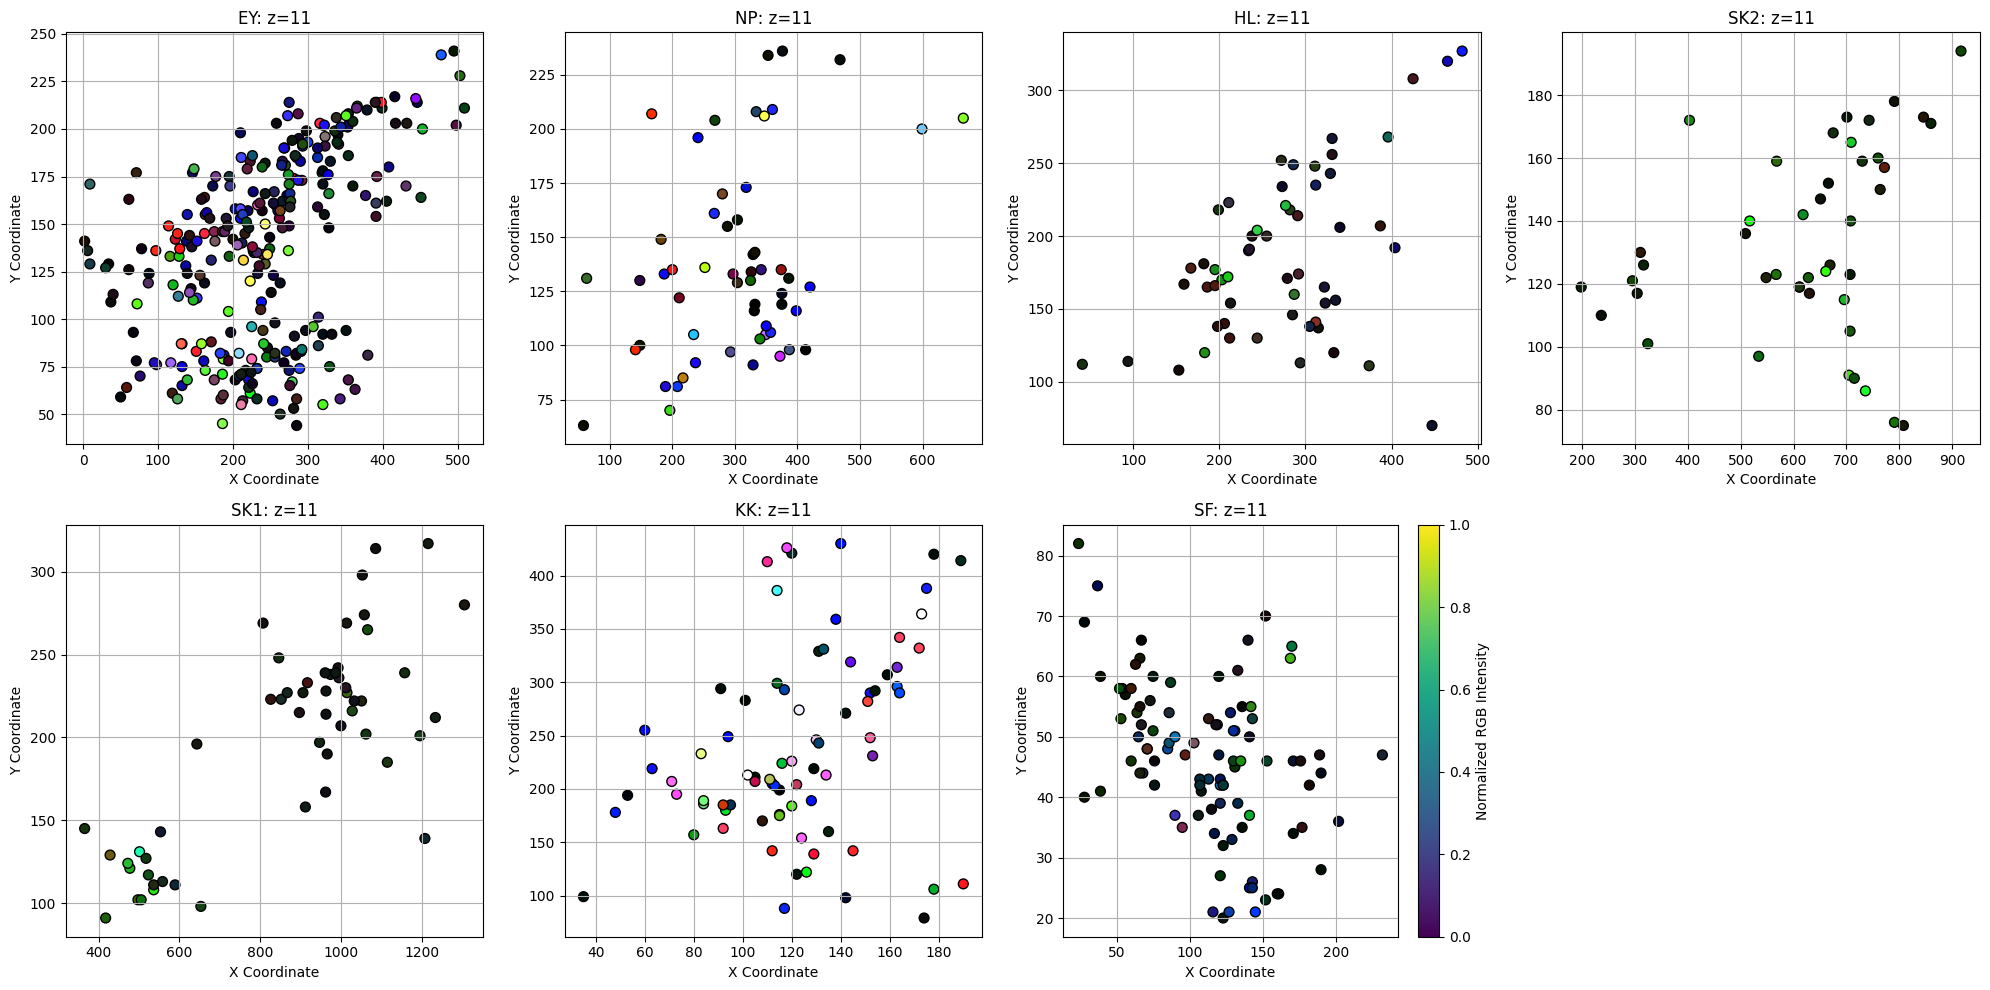

In [9]:
# Load the normalized data
input_path = "/scratch/ne2213/projects/CV-Project/NWBelegans/normalized_data.pkl"
with open(input_path, "rb") as f:
    normalized_data = pickle.load(f)

# Dataset names
dataset_names = ["EY", "NP", "HL", "SK2", "SK1", "KK", "SF"]

# Define z-slice to visualize
z_slice = 11  # Change this value to visualize a different z-slice

# Create a plot for each dataset
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Adjust layout for 7 datasets
axes = axes.flatten()

for i, dataset in enumerate(normalized_data[:7]):  # Loop over the 7 datasets
    # Filter data for the specified z-slice
    slice_data = dataset[dataset['z'] == z_slice]
    
    # If the dataset has no data for this z-slice, skip
    if slice_data.empty:
        axes[i].set_title(f"{dataset_names[i]}: No data for z={z_slice}")
        axes[i].axis("off")
        continue
    
    # Create scatter plot
    scatter = axes[i].scatter(
        slice_data['x'],
        slice_data['y'],
        c=slice_data[['R', 'G', 'B']].values / np.max(slice_data[['R', 'G', 'B']].values),
        s=50,
        edgecolors="k"
    )
    axes[i].set_title(f"{dataset_names[i]}: z={z_slice}")
    axes[i].set_xlabel("X Coordinate")
    axes[i].set_ylabel("Y Coordinate")
    axes[i].grid(True)

# Remove the last (8th) subplot if not used
if len(normalized_data) < 8:
    axes[-1].axis("off")

# Add color bar
fig.colorbar(scatter, ax=axes[-2], location='right', label="Normalized RGB Intensity")  # Adjust the location
plt.tight_layout()
plt.show()


# Mapping Features to a Grid for Passing to ResNet

## Grid 64x64

In [7]:
# Load the normalized data
input_path = "/scratch/ne2213/projects/CV-Project/NWBelegans/normalized_data.pkl"
with open(input_path, "rb") as f:
    normalized_data = pickle.load(f)

# Combine all datasets into a single DataFrame
combined_df = pd.concat(normalized_data, ignore_index=True)
xr_min, xr_max = combined_df['xr'].min(), combined_df['xr'].max()
yr_min, yr_max = combined_df['yr'].min(), combined_df['yr'].max()
print(f"xr range: {xr_min} to {xr_max}")
print(f"yr range: {yr_min} to {yr_max}")


xr range: 0.0 to 1.0000000000000002
yr range: 0.0 to 1.0000000000000002


In [8]:
# Define the grid size
grid_size = 64  # Choose based on desired resolution (e.g., 64, 128, etc.)

# Map normalized xr and yr values to grid coordinates
combined_df['xr_grid'] = (combined_df['xr'] * (grid_size - 1)).astype(int)
combined_df['yr_grid'] = (combined_df['yr'] * (grid_size - 1)).astype(int)

# Verify mapping
print(combined_df[['xr', 'yr', 'xr_grid', 'yr_grid']].head())


         xr        yr  xr_grid  yr_grid
0  0.001965  0.565401        0       35
1  0.013752  0.181435        0       11
2  0.060904  0.489451        3       30
3  0.062868  0.451477        3       28
4  0.070727  0.430380        4       27


In [9]:
import numpy as np

# Initialize an empty grid for each feature
grid = np.zeros((grid_size, grid_size, 4))  # Channels for weight, R, G, B

# Populate the grid
for _, row in combined_df.iterrows():
    x, y = row['xr_grid'], row['yr_grid']
    grid[x, y, 0] += row['weight']
    grid[x, y, 1] += row['R']
    grid[x, y, 2] += row['G']
    grid[x, y, 3] += row['B']

# Normalize the grid (if necessary) to avoid outlier effects
grid[:, :, 1:] /= 65535.0  # Normalize RGB if values are in the 0-65535 range


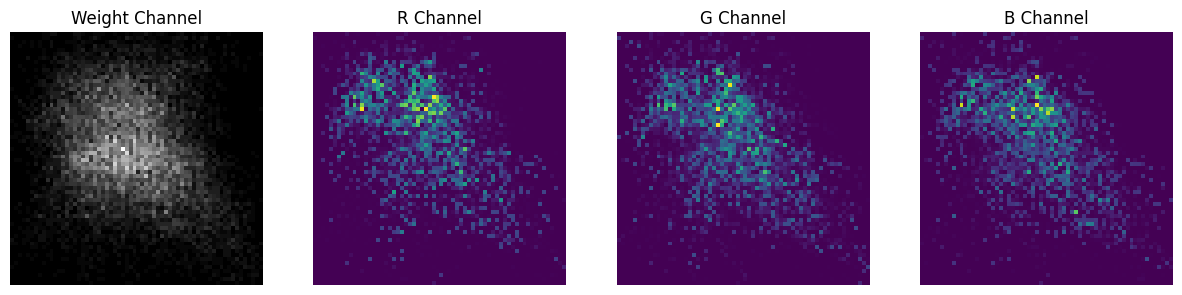

In [10]:
import matplotlib.pyplot as plt

# Visualize each channel
plt.figure(figsize=(15, 5))
for i, channel in enumerate(['Weight', 'R', 'G', 'B']):
    plt.subplot(1, 4, i+1)
    plt.imshow(grid[:, :, i], cmap='gray' if i == 0 else None)
    plt.title(f"{channel} Channel")
    plt.axis('off')
plt.show()


## Grid 128x128

In [11]:
# Load the normalized data
input_path = "/scratch/ne2213/projects/CV-Project/NWBelegans/normalized_data.pkl"
with open(input_path, "rb") as f:
    normalized_data = pickle.load(f)

# Combine all datasets into a single DataFrame
combined_df = pd.concat(normalized_data, ignore_index=True)
xr_min, xr_max = combined_df['xr'].min(), combined_df['xr'].max()
yr_min, yr_max = combined_df['yr'].min(), combined_df['yr'].max()
print(f"xr range: {xr_min} to {xr_max}")
print(f"yr range: {yr_min} to {yr_max}")


xr range: 0.0 to 1.0000000000000002
yr range: 0.0 to 1.0000000000000002


In [12]:
# Define the grid size
grid_size = 128  # Choose based on desired resolution (e.g., 64, 128, etc.)

# Map normalized xr and yr values to grid coordinates
combined_df['xr_grid'] = (combined_df['xr'] * (grid_size - 1)).astype(int)
combined_df['yr_grid'] = (combined_df['yr'] * (grid_size - 1)).astype(int)

# Verify mapping
print(combined_df[['xr', 'yr', 'xr_grid', 'yr_grid']].head())


         xr        yr  xr_grid  yr_grid
0  0.001965  0.565401        0       71
1  0.013752  0.181435        1       23
2  0.060904  0.489451        7       62
3  0.062868  0.451477        7       57
4  0.070727  0.430380        8       54


In [13]:
import numpy as np

# Initialize an empty grid for each feature
grid = np.zeros((grid_size, grid_size, 4))  # Channels for weight, R, G, B

# Populate the grid
for _, row in combined_df.iterrows():
    x, y = row['xr_grid'], row['yr_grid']
    grid[x, y, 0] += row['weight']
    grid[x, y, 1] += row['R']
    grid[x, y, 2] += row['G']
    grid[x, y, 3] += row['B']

# Normalize the grid (if necessary) to avoid outlier effects
grid[:, :, 1:] /= 65535.0  # Normalize RGB if values are in the 0-65535 range


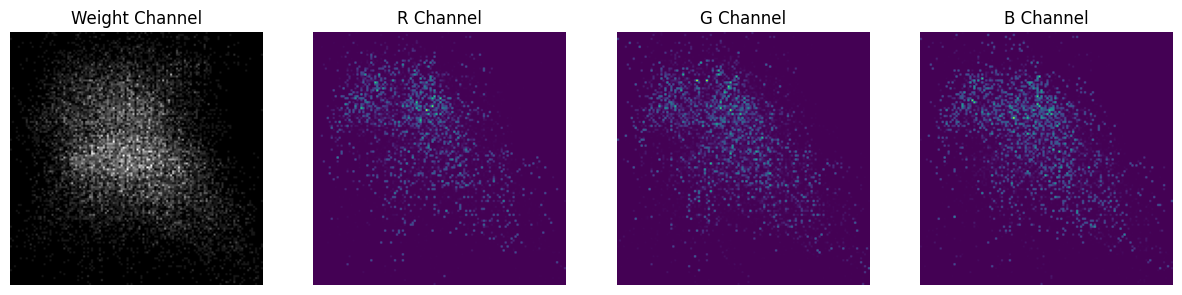

In [14]:
import matplotlib.pyplot as plt

# Visualize each channel
plt.figure(figsize=(15, 5))
for i, channel in enumerate(['Weight', 'R', 'G', 'B']):
    plt.subplot(1, 4, i+1)
    plt.imshow(grid[:, :, i], cmap='gray' if i == 0 else None)
    plt.title(f"{channel} Channel")
    plt.axis('off')
plt.show()
